# Regression and Other Stories: Gay

Simple models (linear and discretized age) and attitudes as a function of age. See Chapter 12 in Regression and Other Stories.

-----

## Load packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains
using CategoricalArrays

## Load data

In [2]:
url = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Gay/data/naes04.csv"
data = CSV.File(HTTP.get(url).body, missingstring="NA") |> DataFrame;

In [3]:
# This block written to match the original notebook
# Could imagine a more Julia-idiomatic way to fill this
age = Array(18:91);
n_age = length(age);
yes = fill(NaN, n_age);
no = fill(NaN, n_age);
d_filt = dropmissing(data,[:age,:gayFavorStateMarriage])


for i in 1:n_age
    if i == n_age
        ok = d_filt[d_filt.age .>= age[i],:]
    else
        ok = d_filt[d_filt.age .== age[i],:]
    end
    
    yes[i] = sum(ok.gayFavorStateMarriage .== "Yes")
    no[i] = sum(ok.gayFavorStateMarriage .== "No")
end

In [4]:
support = yes./(yes.+no)
age_cutpoints = Array(29:10:79)
# R's cut function replicated in CategoricalArrays.jl
age_discrete = cut(age, age_cutpoints,extend=true)
gay_total = DataFrame(Dict(
        "support"=>support, 
        "age"=>age,
        "age_discrete"=>age_discrete
        ));

## Fit linear regression model

In [5]:
@model function m1(age, support)
    
    # sd
    σ ~ truncated(Normal(0,5), 0, Inf)
    
    # Linear
    α ~ Normal(0, .67)
    β ~ Normal(0, 0.5) 
    
    μ = α .+ age * β
    support ~ MvNormal(μ, σ)
end;

In [6]:
model_linear = m1(gay_total.age, gay_total.support)
chains_linear = sample(model_linear, NUTS(0.50), 5000)
summarystats(chains_linear)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           α    0.5589    0.0098     0.0001    0.0004   498.7563    1.0026     ⋯
           β   -0.0049    0.0002     0.0000    0.0000   580.7365    1.0026     ⋯
           σ    0.0337    0.0029     0.0000    0.0003    36.4730    1.0556     ⋯
                                                                1 column omitted


In [7]:
@model function m2(age_cat, support)
    
    # sd
    σ ~ truncated(Normal(0,5), 0, Inf)
    
    # Intercept-only
    n_cats = unique(age_cat)
    α ~ filldist(Normal(0, .67), length(n_cats))
    
    int = α[age_cat]
    support ~ MvNormal(int, σ)
    
end;

In [8]:
model_binned = m2(levelcode.(gay_total.age_discrete), gay_total.support)
chains_binned = sample(model_binned, NUTS(), 5000)
summarystats(chains_binned)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        α[1]    0.4697    0.0091     0.0001    0.0001   5917.0454    1.0000    ⋯
        α[2]    0.3732    0.0095     0.0001    0.0001   4899.8414    0.9998    ⋯
        α[3]    0.3243    0.0092     0.0001    0.0001   5786.4370    0.9999    ⋯
        α[4]    0.3200    0.0096     0.0001    0.0001   4925.0949    0.9998    ⋯
        α[5]    0.2285    0.0093     0.0001    0.0001   5400.8480    1.0003    ⋯
        α[6]    0.1876    0.0092     0.0001    0.0001   4957.6652    1.0004    ⋯
        α[7]    0.1478    0.0081     0.0001    0.0001   6562.9124    1.0000    ⋯
           σ    0.0294    0.0026     0.0000    0.0000   3795.8276    1.0003    ⋯
                                                                1 column omitted


## Plot linear regression model

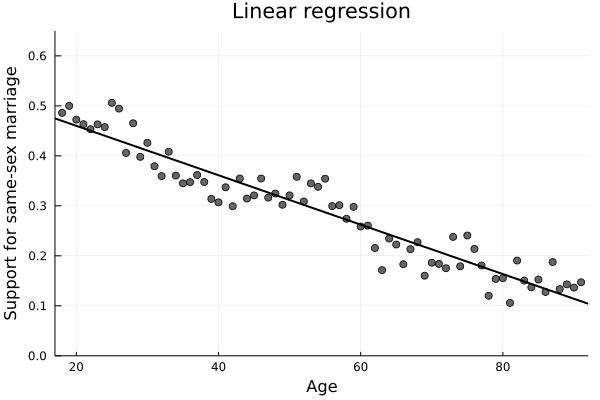

In [9]:
params_linear = get(chains_linear, [:σ, :α, :β])
p=scatter(
    age,support,
    xlim=(minimum(age)-1, maximum(age)+1),
    ylim=(0,0.65),
    xlabel="Age",
    ylabel="Support for same-sex marriage",
    title="Linear regression",
    legend=false,
    color=:gray40
)
plot!(
    minimum(age)-1:1:maximum(age)+1,
    x-> mean(params_linear.α) + mean(params_linear.β) * x,
    color=:black, linewidth=2
)

## Plot discretized age model

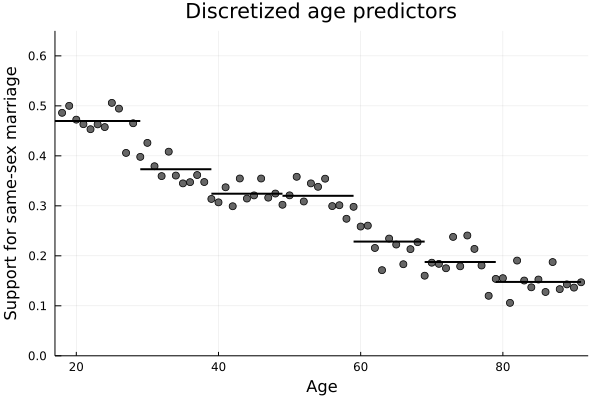

In [10]:
params_binned = get(chains_binned, [:σ, :α])
p=scatter(
    age,support,
    xlim=(minimum(age)-1, maximum(age)+1),
    ylim=(0,0.65),
    xlabel="Age",
    ylabel="Support for same-sex marriage",
    title="Discretized age predictors",
    legend=false, color=:gray40
)
# Iterate over cutpoints (probably a cleaner way to do this bit)
for (i,max) in enumerate(age_cutpoints)
    y = mean(params_binned.α[i])
    if i ==1
        plot!([17,age_cutpoints[i]],[y,y], color=:black,linewidth=2)
    else
        plot!([age_cutpoints[i-1],age_cutpoints[i]],[y,y], color=:black,linewidth=2)
    end
end
# Catch last break 
plot!(
    [last(age_cutpoints), maximum(age)],
    [mean(params_binned.α[7]), mean(params_binned.α[7])],
    color=:black, linewidth=2
)
display(p)